In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
## load data for the roi of interest    
# roi_of_interest = 'roi_1'
roi_of_interest = 'roi_1'
# roi_of_interest  = 'roi_3'
# roi_of_interest = 'roi_2'
# roi_of_interest = 'run2_roi_2'
# roi_of_interest = 'run2_roi_3'

# load the sg_object
with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [8]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [9]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [10]:
merged_gdf = sg_obj.gdf

In [11]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])

obs_cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes'] + cols_to_keep 

adata_genes.obs = df[obs_cols]

adata_genes.obs.index = [str(x) for x in adata_genes.obs.index]

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_64841/749676134.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [12]:
adata_genes.obs.groupby('bc_cluster').size() > 10

bc_cluster
0.0       False
1.0       False
2.0       False
3.0       False
4.0        True
          ...  
2406.0    False
2407.0    False
2408.0    False
2409.0    False
2410.0    False
Length: 2411, dtype: bool

Metrics based on filtering by 3 barcodes per cluster
Average cells per cluster 8.838983050847459
Number of clusters 826
Metrics based on additionally filtering by 10 cells per cluster
Average cells per cluster 47.52459016393443
Number of clusters 122


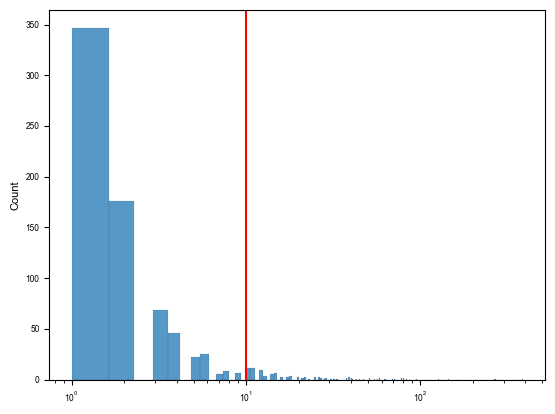

In [13]:
### FILTERING CLONES DOWN TO THOSE WITH MANY BARCODES AND/OR MANY CELLS

n_bcs_per_cluster_cutoff = 3
n_cells_per_cluster_cutoff = 10


## first get a GDF that's just those with at least 10 cells
cluster_sizes = adata_genes.obs.groupby('bc_cluster').size()
large_clusters = cluster_sizes[cluster_sizes >= 10].index.tolist()

large_clusters_gdf = large_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(large_clusters)]

## now, let's look at onces with at least 10 cells and 3 barcodes per clone.
confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

print(f'Metrics based on filtering by {n_bcs_per_cluster_cutoff} barcodes per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))

sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)

print(f'Metrics based on additionally filtering by {n_cells_per_cluster_cutoff} cells per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))

confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_clusters.obs['bc_cluster'].values)]






In [14]:
np.unique(confident_clusters.obs['bc_cluster'].values)

array([  16.,   18.,   25.,   31.,   38.,   47.,   49.,   51.,   52.,
         56.,   58.,   62.,   71.,   72.,   73.,   86.,   88.,   90.,
        102.,  104.,  108.,  114.,  119.,  120.,  129.,  130.,  132.,
        133.,  134.,  138.,  142.,  146.,  157.,  158.,  161.,  170.,
        173.,  175.,  176.,  179.,  185.,  193.,  212.,  216.,  217.,
        220.,  228.,  238.,  246.,  247.,  269.,  273.,  278.,  287.,
        305.,  308.,  321.,  322.,  326.,  328.,  329.,  331.,  334.,
        338.,  345.,  354.,  355.,  378.,  380.,  384.,  419.,  423.,
        432.,  433.,  444.,  448.,  451.,  483.,  484.,  521.,  525.,
        543.,  552.,  561.,  578.,  580.,  584.,  585.,  606.,  618.,
        622.,  627.,  640.,  670.,  671.,  707.,  740.,  764.,  783.,
        785.,  812.,  814.,  820.,  894.,  903.,  905.,  945.,  975.,
       1025., 1043., 1068., 1096., 1116., 1138., 1152., 1164., 1178.,
       1247., 1386., 1514., 1586., 2127.])

In [15]:
sg_obj.gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
0,"POLYGON ((36275.000 4658.000, 36292.000 4660.0...","POLYGON ((36271.838 4648.513, 36256.838 4653.5...",POINT (36341.387 4739.044),36341.386713,4739.043956,27532.712954,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
1,"POLYGON ((34906.000 4877.000, 34922.000 4878.0...","POLYGON ((34903.369 4867.352, 34881.369 4873.3...",POINT (34899.447 4940.129),34899.446723,4940.129096,13129.594054,10,10,3.0,0.0,...,0.0,0.0,0.0,0.0,222.0,bc_052-bc_064,"['bc_052', 'bc_064']",2.0,"['bc_052', 'bc_064']",2.0
2,"POLYGON ((34012.000 5411.000, 34025.000 5411.0...","POLYGON ((34011.005 5401.050, 33991.005 5403.0...",POINT (33987.391 5458.956),33987.391319,5458.955598,11236.124361,100,100,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
3,"POLYGON ((37351.000 7869.000, 37360.000 7870.0...","POLYGON ((37346.809 7859.920, 37333.809 7865.9...",POINT (37353.893 7892.230),37353.893499,7892.230290,3611.468289,1000,1000,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
4,"POLYGON ((29231.000 20498.000, 29262.000 20504...","POLYGON ((29221.881 20493.896, 29212.881 20513...",POINT (29282.097 20534.206),29282.097479,20534.206373,9471.708014,10000,10000,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39626,"POLYGON ((21148.000 20492.000, 21157.000 20492...","POLYGON ((21142.265 20483.808, 21132.265 20490...",POINT (21153.838 20540.837),21153.838207,20540.836892,7994.374053,9995,9995,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
39627,"POLYGON ((35098.000 20493.000, 35117.000 20496...","POLYGON ((35092.631 20484.563, 35081.631 20491...",POINT (35118.530 20534.530),35118.530262,20534.530489,6703.985713,9996,9996,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,[],0.0
39628,"POLYGON ((21847.000 20494.000, 21864.000 20494...","POLYGON ((21843.672 20484.570, 21826.672 20490...",POINT (21852.132 20550.979),21852.132119,20550.979033,11788.400907,9997,9997,1.0,1.0,...,0.0,0.0,1.0,0.0,216.0,bc_035-bc_063-bc_074,"['bc_035', 'bc_063', 'bc_074']",3.0,"['bc_019', 'bc_035', 'bc_063', 'bc_074']",4.0
39629,"POLYGON ((19268.000 20496.000, 19296.000 20507...","POLYGON ((19260.929 20488.929, 19253.967 20495...",POINT (19291.880 20569.226),19291.879625,20569.225553,12322.642590,9998,9998,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,['bc_068'],1.0


In [31]:
### We can look at which clusters have the highest SFRP1 expression. Cluster 31 has the hightest.

# confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].median().sort_values(ascending=False).head(10)
# print('SFRP1 in confident clusters (>=3 barcodes, >=10 cells)')
# print('Fraction of cells with SFRP1 > 1')
# print(confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].apply(lambda x: (x > 1).sum() / len(x)).sort_values(ascending=False).head(10))
# print('Mean SFRP1 expression')
# print(confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10))

print('ALL CLONES ')

# print('Fraction of cells with SFRP1 > 1')
# print(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].apply(lambda x: (x > 1).sum() / len(x)).sort_values(ascending=False).head(10))
print('Mean SFRP1 expression')
print(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10))

# print number of objects in groupby


ALL CLONES 
Mean SFRP1 expression
bc_cluster
812.0     1.051724
1196.0    0.739726
279.0     0.562500
683.0     0.533333
88.0      0.512821
755.0     0.454545
133.0     0.400000
291.0     0.400000
777.0     0.380952
86.0      0.362500
Name: SFRP1, dtype: float64


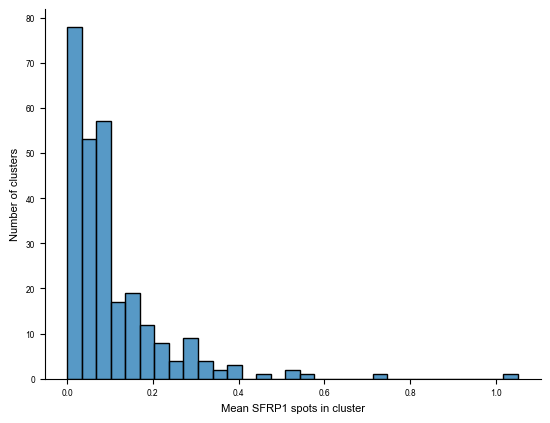

In [53]:
## SFRP1 clones of interest
clones_by_roi = {
    # 'roi_1':[812],
    'roi_1':[1196],
    'roi_2':[31],
    'roi_3':[],
    'run2_roi_2':[40,1262],
    'run2_roi_3':[],

}

### Define SFRP1 regions of interest

clone_lims = {
    # 'roi_1': [[3000, 7000, 33000, 40000]], # xmin, xmax, ymin, ymax
    # # 'roi_2': [1000, 2000, 1000, 2000],
    # 'roi_3': [[18000,25000,12000,19000],
              
    #           ],
    'roi_1': {812:[9600, 20000, 29000, 35000],
            #   9807.994152367379 19362.574963843806 29791.2498401038 34308.88749739094
        1196:[12000, 15000, 42000, 49000]},

    'run2_roi_2': {40:[6000, 15000, 20000, 31000],
                #    698:[18000, 23000, 48000, 57000],
                   205:[18000, 23000, 48000, 57000],
                   
                #    40:[8000, 18000, 20000, 30000],
                    # [18000, 23000, 48000, 57000],
                    # [44000, 46000, 41000, 53000],
                    # [8800, 13000, 25000, 53000],
                    # [1000, 2000, 1000, 2000],
    },
    'run2_roi_3': {182:[25000, 30000, 28000, 32000],
                    695:[25000, 30000, 28000, 32000],
                    2728:[25000, 30000, 28000, 32000],
                #    1848:[25000, 30000, 28000, 32000],
                    # [27000, 32000, 10000, 15000],
                    # [44000, 46000, 41000, 53000],
                    # [1000, 2000, 1000, 2000],
    },

}


In [80]:
large_clusters_gdf[large_clusters_gdf['bc_cluster'] == cluster_of_interest]['bc_cluster_bc_names'].values[0]

'bc_001-bc_074'

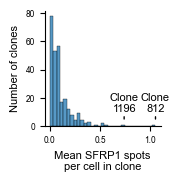

In [88]:

plt.figure(figsize=(1.5,1.5))
clusters_of_interest = clone_lims[roi_of_interest].keys() # get the clusters of interest for the roi of interest

sns.histplot(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean())
plt.xlabel('Mean SFRP1 spots\nper cell in clone')
plt.ylabel('Number of clones')


for cluster_of_interest in clusters_of_interest:

    cluster_barcode_names = large_clusters_gdf[large_clusters_gdf['bc_cluster'] == cluster_of_interest]['bc_cluster_bc_names'].values[0]
    # annotate the cluster of interest on the histogram
    plt.annotate(f'Clone\n{cluster_of_interest}',
                    xy=(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean()[cluster_of_interest], 5),
                    xytext=(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean()[cluster_of_interest], 10),
                    arrowprops=dict(arrowstyle='-',facecolor='black',),ha='center',
                    fontsize=8)
                 

    # plt.axvline(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean()[cluster_of_interest], color='red', linestyle='--')



sns.despine()
plt.savefig(f'../graphs/other_rois/{roi_of_interest}/SFRP1_mean_spots_per_cluster_large_labeled.pdf',bbox_inches='tight',dpi=300)

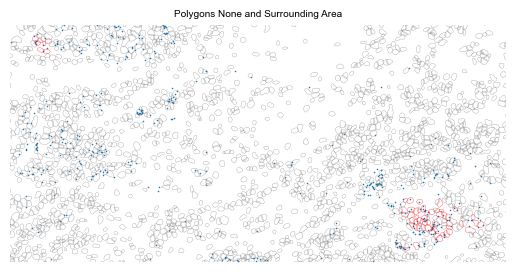

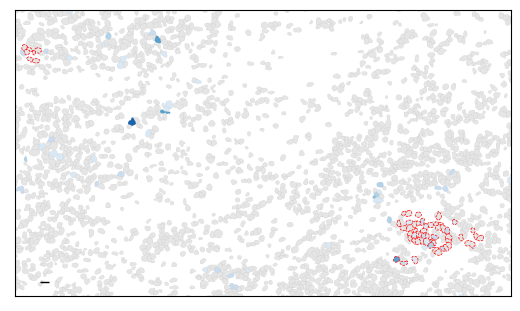

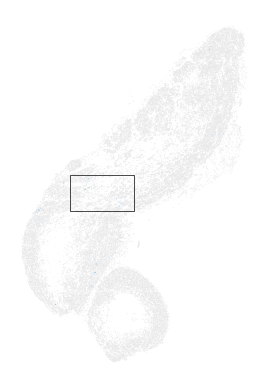

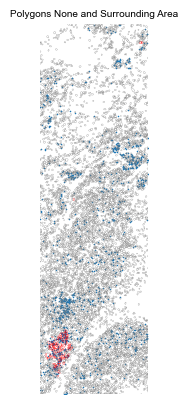

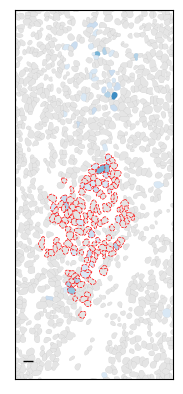

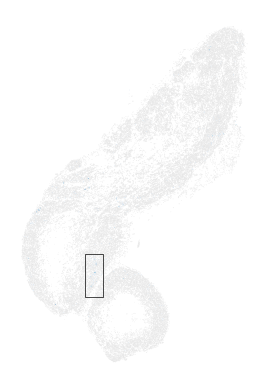

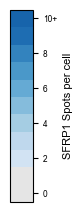

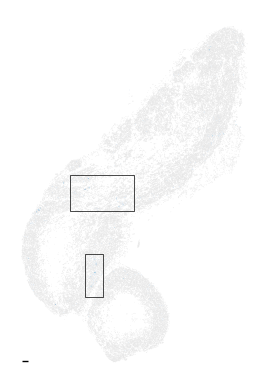

In [62]:
gene_of_interest = 'SFRP1'
# clusters_of_interest = confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)['bc_cluster']
# clusters_of_interest = confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).index[:10]
clusters_of_interest = large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).index[:5]

clusters_of_interest = clone_lims[roi_of_interest].keys() # get the clusters of interest for the roi of interest
# clusters_of_interest = [40,205]
# large_clusters_gdf[large_clusters_gdf['bc_cluster'] == 862][['SFRP1','bc_cluster','bc_cluster_bc_names']]

for cluster_of_interest in clusters_of_interest:

  # get the cells associated with the manual cluster
  # cluster_cells = list(confident_clusters.obs[confident_clusters.obs['bc_cluster'].isin([cluster_of_interest])]['object_id'].values)
  cluster_cells = list(large_clusters_gdf[large_clusters_gdf['bc_cluster'].isin([cluster_of_interest])]['cell_id'].values)
  # cluster_cells = [int(x) for x in cluster_cells]
  central_ix = int(len(cluster_cells)/2) 
  cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

  # region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=1,id_field='cell_id')

  fig,ax = plt.subplots()
  tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                              color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                                #  id_field='object_id',
                                # id_field='cell_id',
                              annotate=False,image_scale=0.1,
                              focal_outline_color='r',other_outline_color='gray',
                              interior_marker='.',single_mode=False,lw=0.2,
                              exterior_marker='.',marker_size=5,ax=ax)


  # ymin,ymax = plt.ylim()
  # xmin,xmax = plt.xlim()

  xmin,xmax,ymin,ymax = clone_lims[roi_of_interest][cluster_of_interest]

  plt.axis('off')
  # plt.title()
  plt.gca().invert_yaxis()

  ### PLOT THE ZOOMED IN IMAGE     
  fig,ax = plt.subplots()

  vmin = 2
  vmax = 10

  norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

  bbox = box(xmin,ymin,xmax,ymax)
  other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

  merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

  cmap = matplotlib.cm.get_cmap('Blues').copy()
  cmap = cmap(np.linspace(0.15, 0.8, 256))

  cmap = matplotlib.colors.ListedColormap(cmap)
  cmap.set_under('#e5e5e5') # set low values to gray

  merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                  vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

  this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
  # this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

  merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

  # print(merged_gdf_focal.shape)
  merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                  vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')
    # merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
    #               vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

  # Add the patch to the Axes
  plt.xlim(xmin,xmax)
  plt.ylim(ymin,ymax)
  plt.gca().invert_yaxis()

  ax.set_xticks([])
  ax.set_yticks([])

  scale_bar_length_um = 20 # 100um scale bar
  scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
  scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                            scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
  plt.gca().add_patch(scale_bar)
  # ax.set_facecolor('#F5F5F5')
  plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_zoom_grayed.pdf',bbox_inches='tight')


  ### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
  fig,ax = plt.subplots()

  merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                  edgecolor='#d9d9d9',linewidth=0.0)

  # rectangle where magnification is
  rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

  ax.set_facecolor('#F5F5F5')
  plt.axis('off')
  plt.gca().invert_yaxis()

  # scale_bar_length_um = 100 # 100um scale bar
  # scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
  # scale_bar = matplotlib.patches.Rectangle((xmin+(0.1*((xmax-xmin))),ymax-(0.1*(ymax-ymin))), 
  #                                           scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
  # plt.gca().add_patch(scale_bar)

  # plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.pdf',bbox_inches='tight',transparent=True)
  plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_full_grayed.png',dpi=500,bbox_inches='tight',transparent=True)



### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.3,2.5))
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])

plt.savefig(f'../graphs/other_rois/{roi_of_interest}/SFRP1_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)

fig,ax = plt.subplots()

merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.0)

for cluster_of_interest in clusters_of_interest:

  xmin,xmax,ymin,ymax = clone_lims[roi_of_interest][cluster_of_interest]
  # rectangle where magnification is
  rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

scale_bar_length_um = 100 # 1000um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

ax.set_facecolor('#F5F5F5')
plt.axis('off')
plt.gca().invert_yaxis()
plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_full_grayed_allFeaturedClones.png',dpi=500,bbox_inches='tight',transparent=True)





In [ ]:
# plot SFRP1 spots for the whole roi

# open spots file
spots_df = pd.read_csv(tools.roi_file_paths[roi_of_interest]["spots_file"])

<Figure size 640x480 with 0 Axes>

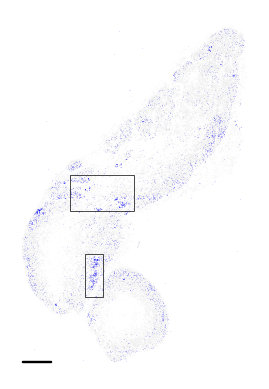

In [66]:
# plt.figure()
gene_of_interest = 'SFRP1'
plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)
spots_gene = spots_df[spots_df['name']==gene_of_interest]
plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color='b')

for cluster_of_interest in clusters_of_interest:

  xmin,xmax,ymin,ymax = clone_lims[roi_of_interest][cluster_of_interest]
  # rectangle where magnification is
  rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
  # Add the patch to the Axes
  plt.gca().add_patch(rect)

xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

scale_bar_length_um = 500 # 500um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

plt.gca().invert_yaxis()
plt.axis('off')
plt.savefig(f'../graphs/other_rois/{roi_of_interest}/{roi_of_interest}_allFeaturedClones_SFRP1spots.png',dpi=500,bbox_inches='tight',transparent=True)


<Figure size 640x480 with 0 Axes>

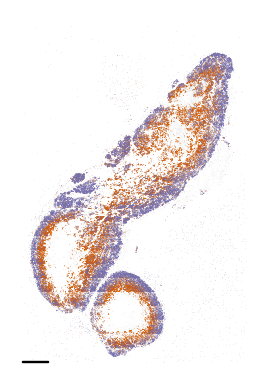

In [68]:
gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            # 'SFRP1',
                ]

gene_colors = {
               'VEGFA':'#d95f02',
               'MITF':'#7570b3',  
               }


plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

for gene_of_interest in gene_list:

    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]
    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color=gene_colors[gene_of_interest])

xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

scale_bar_length_um = 500 # 500um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

plt.gca().invert_yaxis()
plt.axis('off')

# plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_VEGFA_MITF_full.png',dpi=500,bbox_inches='tight',transparent=True)

    

In [ ]:
gene_of_interest = 'SFRP1'
# plt.figure()
# sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)
# spots_gene = spots_df[spots_df['name']==gene_of_interest]
# plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color='b')

for cluster_of_interest in clusters_of_interest:

  xmin,xmax,ymin,ymax = clone_lims[roi_of_interest][cluster_of_interest]
  # rectangle where magnification is
  rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
  # Add the patch to the Axes
  plt.gca().add_patch(rect)

In [55]:
### Define SFRP1 regions of interest

box_lims = {
    'roi_1': [[3000, 7000, 33000, 40000],
              [12000, 15000, 42000, 49000],
              [9600, 20000, 29000, 35000],
              
              ], # xmin, xmax, ymin, ymax
    # 'roi_2': [1000, 2000, 1000, 2000],
    'roi_3': [[18000,25000,12000,19000],
              
              ],

    'run2_roi_2': [
                    [6000, 15000, 20000, 31000],
                    # [8000, 18000, 20000, 30000],
                    [18000, 23000, 48000, 57000],
                    # [44000, 46000, 41000, 53000],
                    # [8800, 13000, 25000, 53000],
                    # [1000, 2000, 1000, 2000],
                   ],
    'run2_roi_3': [[24000, 31000, 27000, 33000],
                    [27000, 32000, 10000, 15000],
                    # [44000, 46000, 41000, 53000],
                    # [1000, 2000, 1000, 2000],
                   ],

}





<Figure size 640x480 with 0 Axes>

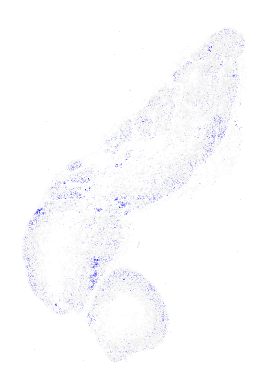

In [56]:
# plt.figure()
gene_of_interest = 'SFRP1'

# for 
plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)
spots_gene = spots_df[spots_df['name']==gene_of_interest]
plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color='b')

# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

# plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_SFRP1_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_SFRP1_full_withaxis.png',dpi=500,bbox_inches='tight',transparent=True)
# plt.savefig(f'../graphs/space_VEGFA_MITF_full.png',dpi=500,bbox_inches='tight',transparent=True)

plt.axis('off')
plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_SFRP1_full.png',dpi=500,bbox_inches='tight',transparent=True)

    

In [89]:
from shapely.geometry import Point
from shapely.ops import unary_union
import geopandas as gpd

In [106]:
distance_um = 100  # 30um is roughly 3 cell lengths

for distance_um in [30,100,1000,5000]:
    distance_px = distance_um / tools.sg_pixel_size  # Simplified conversion

    # Using buffer and spatial join
    # Create a buffer around all cluster cells
    cluster_union = unary_union(cluster_cells.geometry)
    buffer_zone = cluster_union.buffer(distance_px)
    # Find all cells that intersect with the buffer zone
    neighboring_cells = sg_obj.gdf[sg_obj.gdf.geometry.intersects(buffer_zone)]
    # exclude the original cluster cells from the result
    neighboring_cells_only = neighboring_cells[neighboring_cells['bc_cluster'] != cluster_of_interest]
    print(distance_um,len(neighboring_cells_only))

30 64
100 64
1000 75
5000 105



T-test between cluster and region neighboring cells
Cluster cells:58, Regional cells:2385)
T-statistic: 10.553688072915495, P-value: 1.736566698092116e-25

T-test between cluster 812 and neighboring cells (100um)
Cluster cells:58, Neighboring cells:37
T-statistic: 2.9590093798465458, P-value: 0.003914164986255997

T-test between cluster and region neighboring cells
Cluster cells:146, Regional cells:1257)
T-statistic: 7.40744475669461, P-value: 2.2170554896876084e-13

T-test between cluster 1196 and neighboring cells (100um)
Cluster cells:146, Neighboring cells:61
T-statistic: 3.7860226899376035, P-value: 0.00020102506169831138


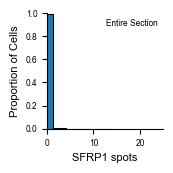

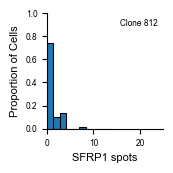

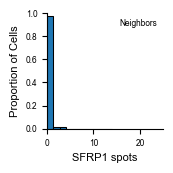

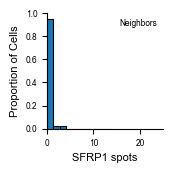

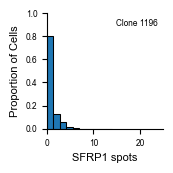

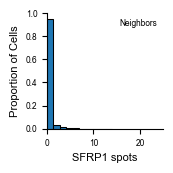

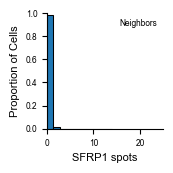

In [99]:
# now let's plot the distributino of clones within the clone, compared to neighboring cells and the entire tumor

counts,bins = np.histogram(sg_obj.gdf['SFRP1'].dropna().tolist(),)

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Entire Section',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(sg_obj.gdf['SFRP1'].dropna().tolist(),bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}/{roi_of_interest}_SFRP1_allcells.pdf',bbox_inches='tight',transparent=True)

for cluster_of_interest in clusters_of_interest:

    cluster_cells = sg_obj.gdf[sg_obj.gdf['bc_cluster'] == cluster_of_interest]

    box_xlims = clone_lims[roi_of_interest][cluster_of_interest][:2]  # xmin, xmax
    box_ylims = clone_lims[roi_of_interest][cluster_of_interest][2:]  # ymin, ymax

    gdf_within_region = sg_obj.gdf.cx[box_xlims[0]:box_xlims[1], box_ylims[0]:box_ylims[1]]
    regional_cells_only = gdf_within_region[~(gdf_within_region['cell_id'].isin(cluster_cells))]

    # Convert distance from um to pixels
    distance_um = 100  # 100um is roughly 5-10 cell lengths
    distance_px = distance_um / tools.sg_pixel_size  # Simplified conversion

    # Using buffer and spatial join
    # Create a buffer around all cluster cells
    cluster_union = unary_union(cluster_cells.geometry)
    buffer_zone = cluster_union.buffer(distance_px)
    # Find all cells that intersect with the buffer zone
    neighboring_cells = regional_cells_only[regional_cells_only.geometry.intersects(buffer_zone)]
    # exclude the original cluster cells from the result
    neighboring_cells_only = neighboring_cells[neighboring_cells['bc_cluster'] != cluster_of_interest]
    
    
    plt.figure(figsize=(1.5,1.5))
    ax = plt.gca()
    # entire tumor
    # ax = plt.subplot(1,3,3)
    plt.text(s=f'Clone {cluster_of_interest}',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
    # plt.title('Entire tumor')
    sns.histplot(cluster_cells['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
    plt.ylim(0,1)
    plt.xlim(0,25)
    plt.xlabel('SFRP1 spots')
    plt.ylabel('Proportion of Cells')
    ax.spines[['right', 'top']].set_visible(False)
    plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_histograms_clone.pdf',bbox_inches='tight',transparent=True)

    ## Plot distribution of cells in the region
    plt.figure(figsize=(1.5,1.5))
    ax = plt.gca()
    # neighbors
    # ax = plt.subplot(1,3,2)
    plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
    # plt.title('Clone 31 neighboring cells')
    sns.histplot(regional_cells_only['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
    plt.ylim(0,1)
    plt.xlim(0,25)
    plt.xlabel('SFRP1 spots')
    plt.ylabel('Proportion of Cells')
    ax.spines[['right', 'top']].set_visible(False)
    plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_histograms_RegionNeighbors.pdf',bbox_inches='tight',transparent=True)

    ## Plot distribution of neighboring cells
    plt.figure(figsize=(1.5,1.5))
    ax = plt.gca()
    # neighbors
    # ax = plt.subplot(1,3,2)
    plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
    # plt.title('Clone 31 neighboring cells')
    sns.histplot(neighboring_cells_only['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
    plt.ylim(0,1)
    plt.xlim(0,25)
    plt.xlabel('SFRP1 spots')
    plt.ylabel('Proportion of Cells')
    ax.spines[['right', 'top']].set_visible(False)
    plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_histograms_Neighbors{distance_um}um.pdf',bbox_inches='tight',transparent=True)


    from scipy.stats import ttest_ind
    # t-test between the cluster and regional cells 
    t_stat, p_val = ttest_ind(cluster_cells['SFRP1'].dropna(), regional_cells_only['SFRP1'].dropna())
    print('\nT-test between cluster and region neighboring cells')
    print(f'Cluster cells:{len(cluster_cells)}, Regional cells:{len(regional_cells_only)})')
    print(f'T-statistic: {t_stat}, P-value: {p_val}')

    # from scipy.stats import ttest_ind
    # t-test between the cluster and regional cells 
    t_stat, p_val = ttest_ind(cluster_cells['SFRP1'].dropna(), neighboring_cells_only['SFRP1'].dropna())
    print(f'\nT-test between cluster {cluster_of_interest} and neighboring cells ({distance_um}um)')
    print(f'Cluster cells:{len(cluster_cells)}, Neighboring cells:{len(neighboring_cells_only)}')
    print(f'T-statistic: {t_stat}, P-value: {p_val}')





In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colors import to_hex

def create_unique_colormap_with_nan(categories, nan_color='lightgrey'):
    """Create a colormap with guaranteed unique colors for each category, with NaN handling"""
    n_colors = len(categories)
    
    if n_colors <= 20:
        # Use tab20 for better color distinction with small numbers
        base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
        colors = base_colors[:n_colors]
    else:
        # Generate colors using golden ratio for better distribution
        golden_ratio = 0.618033988749895
        colors = []
        for i in range(n_colors):
            hue = (i * golden_ratio) % 1
            # Vary saturation and value slightly to increase distinction
            sat = 0.6 + 0.4 * ((i % 3) / 3)
            val = 0.7 + 0.3 * ((i % 2))
            colors.append(mcolors.hsv_to_rgb([hue, sat, val]))
    
    # Create colormap and set bad values (NaN) to the specified color
    cmap = mcolors.ListedColormap(colors)
    cmap.set_bad(color=nan_color)
    
    return cmap


<Figure size 640x480 with 0 Axes>

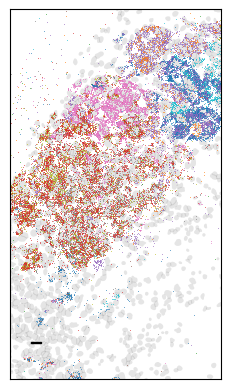

<Figure size 640x480 with 0 Axes>

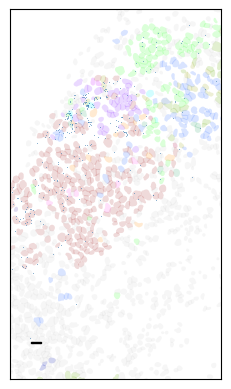

<Figure size 640x480 with 0 Axes>

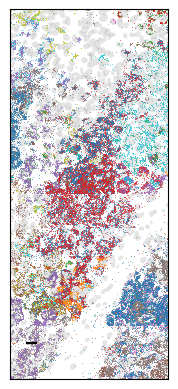

<Figure size 640x480 with 0 Axes>

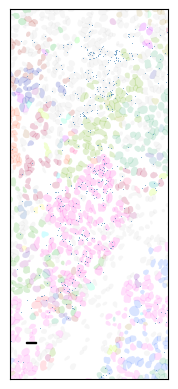

<Figure size 640x480 with 0 Axes>

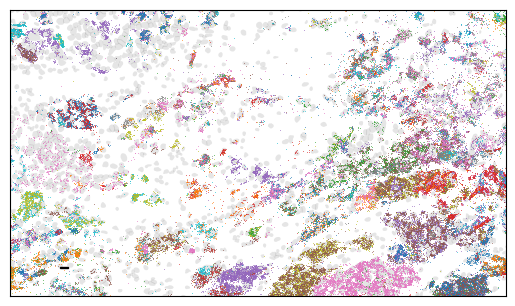

<Figure size 640x480 with 0 Axes>

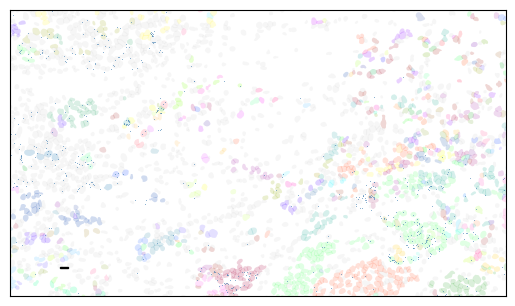

In [58]:
### PLOT SFRP1 expression and barcodes at a given location

gene_of_interest = 'SFRP1'

### zoom in to a region of interest

# box_xlims = [30000,33000]
# box_ylims = [7000,9000]

for region,lims in enumerate(box_lims[roi_of_interest]):
    box_xlims = [lims[0],lims[1]]
    box_ylims = [lims[2],lims[3]]

    spots_within = spots_df[(spots_df['x']>box_xlims[0]) & (spots_df['x']<box_xlims[1]) & (spots_df['y']>box_ylims[0]) & (spots_df['y']<box_ylims[1])]

    bc_cols = [col for col in df.columns if 'bc_' in col and 'cluster' not in col]
    # plot both the barcodes and the gene of interest in separate plots
    plt.figure()

    sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.2)

    for barcode in bc_cols:

        # get the spots for the gene of interest
        spots_gene = spots_within[spots_within['name']==barcode]

        plt.scatter(spots_gene['x'],spots_gene['y'],s=1,alpha=1.0,lw=0,marker='.')

    # plt.axis('off')
    plt.gca().tick_params(bottom=False, left=False)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    # plt.title(gene_of_interest)
    # plt.gca().invert_yaxis()
        
    plt.xlim(box_xlims[0],box_xlims[1])
    plt.ylim(box_ylims[0],box_ylims[1])


    scale_bar_length_um = 20 # 100um scale bar
    scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
    scale_bar = matplotlib.patches.Rectangle((box_xlims[0]+(0.1*(box_xlims[1]-box_xlims[0])),box_ylims[1]-(0.1*(box_ylims[1]-box_ylims[0]))), 
                                            scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
    plt.gca().add_patch(scale_bar)

    plt.gca().invert_yaxis()

    # plt.savefig(f'../graphs/in_vivo_barcode_transcripts_zoom.pdf',bbox_inches='tight',transparent=True)
    plt.savefig(f'../graphs/other_rois/{roi_of_interest}/{roi_of_interest}_region{region}_barcodes.png',dpi=1000,bbox_inches='tight',transparent=True)

    plt.figure()

    # Apply to your data
    regional_stuff = sg_obj.gdf.cx[box_xlims[0]:box_xlims[1], box_ylims[0]:box_ylims[1]]
    unique_clusters = sorted(regional_stuff['bc_cluster'].dropna().unique())
    custom_cmap = create_unique_colormap_with_nan(unique_clusters)

    # Plot
    sg_obj.gdf.plot(column='bc_cluster', categorical=True, lw=0.01, alpha=0.2,
                missing_kwds=dict(color="lightgrey"), cmap=custom_cmap)


    # plot the barcodes

    # sg_obj.gdf.plot(column='bc_cluster',categorical=True,lw=0.01,alpha=0.2,missing_kwds= dict(color = "lightgrey",),cmap='tab20')


    # for gene_of_interest in bc_cols:

        # get the spots for the gene of interest
    spots_gene = spots_within[spots_within['name']==gene_of_interest]
    plt.scatter(spots_gene['x'],spots_gene['y'],s=1,alpha=1.0,lw=0,marker='.',c='steelblue')

    # plt.axis('off')
    plt.gca().tick_params(bottom=False, left=False)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    # plt.title(gene_of_interest)
    # plt.gca().invert_yaxis()
        
    plt.xlim(box_xlims[0],box_xlims[1])
    plt.ylim(box_ylims[0],box_ylims[1])


    scale_bar_length_um = 20 # 100um scale bar
    scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
    scale_bar = matplotlib.patches.Rectangle((box_xlims[0]+(0.1*(box_xlims[1]-box_xlims[0])),box_ylims[1]-(0.1*(box_ylims[1]-box_ylims[0]))), 
                                            scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
    plt.gca().add_patch(scale_bar)

    plt.gca().invert_yaxis()

    # plt.savefig(f'../graphs/in_vivo_barcode_transcripts_zoom.pdf',bbox_inches='tight',transparent=True)
    plt.savefig(f'../graphs/other_rois/{roi_of_interest}/{roi_of_interest}_region{region}_{gene_of_interest}.png',dpi=1000,bbox_inches='tight',transparent=True)


In [33]:
# filter the gdf to cells within the bbox

this_box_lims = box_lims[roi_of_interest][1]

# this_region = large_clusters_gdf.cx[(box(*box_lims[roi_of_interest][1]))]

gdf_within_box = large_clusters_gdf.cx[this_box_lims[0]:this_box_lims[1], this_box_lims[2]:this_box_lims[3]]

gdf_within_box = gdf_within_box.copy()
gdf_within_box.groupby('bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

gdf_within_box.groupby('bc_cluster')['SFRP1'].apply(lambda x: (x > 1).sum()).sort_values(ascending=False).head(10)
# this_region.groupby('bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
1196.0    29
86.0       3
8.0        1
119.0      1
396.0      1
670.0      1
755.0      0
423.0      0
448.0      0
593.0      0
Name: SFRP1, dtype: int64

In [253]:
gdf_within_box[gdf_within_box['bc_cluster']==2728][['SFRP1','bc_cluster','bc_cluster_bc_names']]

,SFRP1,bc_cluster,bc_cluster_bc_names
49071,17.0,2728.0,bc_005
49251,17.0,2728.0,bc_005
49640,1.0,2728.0,bc_005
50389,0.0,2728.0,bc_005
50799,29.0,2728.0,bc_005
50977,4.0,2728.0,bc_005
50990,2.0,2728.0,bc_005
51134,21.0,2728.0,bc_005
51150,14.0,2728.0,bc_005
51156,0.0,2728.0,bc_005


In [252]:
gdf_within_box[gdf_within_box['bc_cluster']==182][['SFRP1','bc_cluster','bc_cluster_bc_names']]

,SFRP1,bc_cluster,bc_cluster_bc_names
48181,25.0,182.0,bc_079
48239,11.0,182.0,bc_079
48284,5.0,182.0,bc_079
48306,10.0,182.0,bc_079
48338,1.0,182.0,bc_079
...,...,...,...
57488,2.0,182.0,bc_079
57541,8.0,182.0,bc_079
57638,49.0,182.0,bc_079
58252,11.0,182.0,bc_079


In [251]:
gdf_within_box[gdf_within_box['bc_cluster']==695][['SFRP1','bc_cluster','bc_cluster_bc_names']]

,SFRP1,bc_cluster,bc_cluster_bc_names
48432,2.0,695.0,bc_003-bc_014
48684,2.0,695.0,bc_003-bc_014
48851,0.0,695.0,bc_003-bc_014
49045,1.0,695.0,bc_003-bc_014
49054,1.0,695.0,bc_003-bc_014
...,...,...,...
59134,0.0,695.0,bc_003-bc_014
59236,0.0,695.0,bc_003-bc_014
59247,1.0,695.0,bc_003-bc_014
59275,0.0,695.0,bc_003-bc_014


In [250]:
gdf_within_box[gdf_within_box['bc_cluster']==1801][['SFRP1','bc_cluster','bc_cluster_bc_names']]

,SFRP1,bc_cluster,bc_cluster_bc_names
48263,0.0,1801.0,bc_059-bc_060-bc_078
48370,0.0,1801.0,bc_059-bc_060-bc_078
48815,2.0,1801.0,bc_059-bc_060-bc_078
48956,0.0,1801.0,bc_059-bc_060-bc_078
49184,3.0,1801.0,bc_059-bc_060-bc_078
49250,0.0,1801.0,bc_059-bc_060-bc_078
49394,1.0,1801.0,bc_059-bc_060-bc_078
49410,0.0,1801.0,bc_059-bc_060-bc_078
49458,0.0,1801.0,bc_059-bc_060-bc_078
49589,1.0,1801.0,bc_059-bc_060-bc_078


In [228]:
gdf_within_box.groupby('bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
2894.0    13.333333
1848.0    11.000000
182.0      9.590698
2728.0     9.380952
1198.0     7.333333
637.0      7.000000
250.0      4.500000
416.0      4.000000
172.0      3.500000
1681.0     3.333333
Name: SFRP1, dtype: float64

In [229]:
gdf_within_box

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
48033,"POLYGON ((27064.000 27840.000, 27077.000 27840...","POLYGON ((27059.939 27830.862, 27032.939 27842...",POINT (27057.518 27912.586),27057.518028,27912.586173,14292.066254,53228,53228,6.0,0.0,...,0.0,0.0,0.0,0.0,1524.0,bc_009,['bc_009'],1.0,"['bc_005', 'bc_009', 'bc_065']",3.0
48139,"POLYGON ((25343.000 27881.000, 25355.000 27881...","POLYGON ((25323.177 27881.183, 25320.380 27883...",POINT (25344.849 27935.049),25344.848890,27935.048819,10677.845262,53323,53323,3.0,0.0,...,0.0,0.0,0.0,0.0,2878.0,bc_033-bc_064,"['bc_033', 'bc_064']",2.0,"['bc_033', 'bc_064']",2.0
48175,"POLYGON ((25439.000 27895.000, 25457.000 27897...","POLYGON ((25435.838 27885.513, 25423.838 27889...",POINT (25457.473 27953.214),25457.473490,27953.214063,13113.359863,53356,53356,6.0,0.0,...,0.0,0.0,0.0,0.0,1346.0,bc_020-bc_066,"['bc_020', 'bc_066']",2.0,"['bc_001', 'bc_020', 'bc_066', 'bc_068']",4.0
48181,"POLYGON ((28811.000 27897.000, 28823.000 27904...","POLYGON ((28801.001 27897.172, 28801.984 27954...",POINT (28861.734 27982.647),28861.734406,27982.647401,17123.006282,53361,53361,6.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,['bc_079'],1.0
48218,"POLYGON ((29123.000 27911.000, 29140.000 27914...","POLYGON ((29119.838 27901.513, 29107.838 27905...",POINT (29120.832 27959.815),29120.831738,27959.815128,8966.396316,53395,53395,2.0,0.0,...,0.0,0.0,0.0,0.0,174.0,bc_022-bc_053-bc_074,"['bc_022', 'bc_053', 'bc_074']",3.0,"['bc_022', 'bc_053', 'bc_074']",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59352,"POLYGON ((28050.000 31954.000, 28053.000 31954...","POLYGON ((28045.528 31945.056, 28040.322 31947...",POINT (28047.045 32020.325),28047.044844,32020.324550,10838.281557,63415,63415,3.0,0.0,...,0.0,0.0,0.0,0.0,1866.0,bc_015-bc_087,"['bc_015', 'bc_087']",2.0,"['bc_015', 'bc_066', 'bc_087']",3.0
59425,"POLYGON ((26495.000 31984.000, 26504.000 31985...","POLYGON ((26490.939 31974.862, 26483.878 31978...",POINT (26510.478 32032.515),26510.477626,32032.515218,9656.195307,63481,63481,4.0,0.0,...,0.0,0.0,0.0,0.0,111.0,bc_006-bc_019-bc_022-bc_031-bc_070-bc_085,"['bc_006', 'bc_019', 'bc_022', 'bc_031', 'bc_0...",6.0,"['bc_006', 'bc_019', 'bc_022', 'bc_031', 'bc_0...",7.0
59436,"POLYGON ((26152.000 31991.000, 26167.000 31992...","POLYGON ((26148.410 31981.667, 26135.410 31986...",POINT (26165.256 32079.937),26165.255677,32079.936633,21615.712962,63491,63491,4.0,1.0,...,0.0,0.0,0.0,0.0,391.0,bc_024,['bc_024'],1.0,"['bc_003', 'bc_014', 'bc_024']",3.0
59437,"POLYGON ((26200.000 31991.000, 26208.000 31992...","POLYGON ((26196.286 31981.715, 26191.286 31983...",POINT (26244.215 32055.764),26244.215279,32055.763579,10809.766632,63492,63492,2.0,0.0,...,0.0,0.0,0.0,0.0,391.0,bc_024,['bc_024'],1.0,['bc_024'],1.0


In [220]:
large_clusters_gdf[large_clusters_gdf['bc_cluster']==182]

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
15214,"POLYGON ((32859.000 16164.000, 32862.000 16165...","POLYGON ((32853.188 16155.863, 32846.188 16160...",POINT (32881.997 16204.921),32881.996918,16204.921109,5903.751355,23691,23691,0.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,['bc_079'],1.0
20740,"POLYGON ((26505.000 18414.000, 26515.000 18416...","POLYGON ((26500.528 18405.056, 26486.528 18412...",POINT (26518.569 18456.845),26518.569088,18456.845367,7491.864127,28665,28665,1.0,0.0,...,0.0,0.0,1.0,0.0,182.0,bc_079,['bc_079'],1.0,"['bc_079', 'bc_085']",2.0
20848,"POLYGON ((26476.000 18451.000, 26495.000 18468...","POLYGON ((26469.026 18443.833, 26432.026 18479...",POINT (26468.756 18500.804),26468.755640,18500.804239,7961.515834,28762,28762,2.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,"['bc_079', 'bc_085']",2.0
37760,"POLYGON ((3147.000 24295.000, 3153.000 24296.0...","POLYGON ((3142.259 24286.195, 3116.259 24300.1...",POINT (3143.940 24315.528),3143.939931,24315.528110,2829.642832,43983,43983,3.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,"['bc_024', 'bc_079']",2.0
39641,"POLYGON ((3676.000 25016.000, 3688.000 25016.0...","POLYGON ((3671.528 25007.056, 3659.528 25013.0...",POINT (3702.451 25058.737),3702.451315,25058.737279,10983.250878,45676,45676,3.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,"['bc_024', 'bc_075', 'bc_079']",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63087,"POLYGON ((30404.000 33343.000, 30474.000 33344...","POLYGON ((30400.543 33333.617, 30381.543 33340...",POINT (30445.404 33396.519),30445.403981,33396.519127,17608.634631,66778,66778,0.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,['bc_079'],1.0
64151,"POLYGON ((29451.000 33741.000, 29460.000 33743...","POLYGON ((29395.018 33840.553, 29395.003 33840...",POINT (29456.245 33811.933),29456.244729,33811.933221,17432.743859,67735,67735,3.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,"['bc_003', 'bc_047', 'bc_066', 'bc_079']",4.0
65077,"POLYGON ((30573.000 34107.000, 30593.000 34109...","POLYGON ((30564.074 34102.517, 30561.608 34103...",POINT (30574.653 34162.453),30574.653072,34162.453155,10790.316104,68569,68569,2.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,"['bc_066', 'bc_079']",2.0
65093,"POLYGON ((30516.000 34112.000, 30530.000 34112...","POLYGON ((30461.147 34226.657, 30461.181 34226...",POINT (30506.489 34179.436),30506.488969,34179.436222,12210.947950,68583,68583,3.0,0.0,...,0.0,0.0,0.0,0.0,182.0,bc_079,['bc_079'],1.0,"['bc_058', 'bc_073', 'bc_079']",3.0


In [161]:
large_clusters_gdf[large_clusters_gdf['bc_cluster']==69]

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
42119,"POLYGON ((2778.000 25696.000, 2805.000 25704.0...","POLYGON ((2746.038 25789.166, 2746.000 25790.0...",POINT (2812.125 25769.646),2812.124789,25769.645854,16058.714039,47906,47906,11.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_047', 'bc_084']",3.0
42393,"POLYGON ((2755.000 25790.000, 2758.000 25790.0...","POLYGON ((2750.200 25781.229, 2749.644 25781.1...",POINT (2783.027 25852.092),2783.026548,25852.092271,12028.718461,48152,48152,4.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_027', 'bc_047', 'bc_084']",4.0
43154,"POLYGON ((2865.000 26089.000, 2885.000 26094.0...","POLYGON ((2804.221 26179.276, 2804.287 26179.3...",POINT (2900.886 26187.469),2900.886210,26187.469244,27924.002412,48838,48838,10.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_027', 'bc_047', 'bc_053', 'bc_0...",5.0
43383,"POLYGON ((2802.000 26169.000, 2830.000 26180.0...","POLYGON ((2794.473 26162.434, 2780.324 26166.3...",POINT (2836.096 26254.075),2836.095684,26254.075189,22439.497677,49043,49043,6.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_027', 'bc_047', 'bc_053', 'bc_0...",5.0
44033,"POLYGON ((2682.000 26431.000, 2696.000 26431.0...","POLYGON ((2679.490 26421.320, 2652.490 26428.3...",POINT (2694.221 26523.148),2694.221208,26523.147858,21152.674686,49629,49629,11.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_027', 'bc_047', 'bc_084']",4.0
44341,"POLYGON ((3077.000 26544.000, 3094.000 26545.0...","POLYGON ((3031.000 26584.980, 3031.000 26586.0...",POINT (3096.605 26587.699),3096.604933,26587.698994,11727.664014,49906,49906,2.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_018', 'bc_084']",3.0
44490,"POLYGON ((2774.000 26598.000, 2821.000 26603.0...","POLYGON ((2766.191 26591.753, 2754.191 26606.7...",POINT (2794.375 26669.412),2794.375276,26669.412009,16456.574340,50039,50039,12.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_047', 'bc_084']",3.0
44789,"POLYGON ((3080.000 26700.000, 3097.000 26700.0...","POLYGON ((3077.127 26690.422, 3067.127 26693.4...",POINT (3086.657 26725.914),3086.657340,26725.913622,5234.913445,50308,50308,0.0,0.0,...,0.0,0.0,0.0,1.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_038', 'bc_084']",3.0
44812,"POLYGON ((3156.000 26709.000, 3176.000 26711.0...","POLYGON ((3154.440 26699.122, 3135.440 26702.1...",POINT (3150.391 26751.015),3150.391353,26751.015182,8154.358369,50329,50329,2.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,['bc_008'],1.0
44975,"POLYGON ((3191.000 26758.000, 3198.000 26762.0...","POLYGON ((3129.431 26839.881, 3134.753 26852.8...",POINT (3193.751 26810.911),3193.750871,26810.910864,13388.441972,50476,50476,2.0,0.0,...,0.0,0.0,0.0,0.0,69.0,bc_008-bc_084,"['bc_008', 'bc_084']",2.0,"['bc_008', 'bc_084']",2.0


In [31]:
### what are the barcodes associated with this cluster???

gdf_within_box = large_clusters_gdf.cx[box_xlims[0]:box_xlims[1], box_ylims[0]:box_ylims[1]]
gdf_within_box.groupby('bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

gdf_within_box[gdf_within_box['bc_cluster'] == 40][['bc_cluster','bc_cluster_bc_names','SFRP1']]
# .isin([reg])

cluster_of_interest = 40

neighboring_cells = gdf_within_box[~(gdf_within_box['bc_cluster'] == cluster_of_interest)]['cell_id'].values

In [182]:
from shapely.geometry import Point
from shapely.ops import unary_union
import geopandas as gpd

# Get your cluster cells
cluster_cells = sg_obj.gdf[sg_obj.gdf['bc_cluster'] == 40]
# cluster_cells['geometry'] = cluster_cells['nucleus_centroid']


# Convert distance from um to pixels
distance_um = 30  # 30um is roughly 3 cell lengths
distance_px = distance_um / tools.sg_pixel_size  # Simplified conversion

# Method 1: Using buffer and spatial join
# Create a buffer around all cluster cells
cluster_union = unary_union(cluster_cells.geometry)
buffer_zone = cluster_union.buffer(distance_px)

# Find all cells that intersect with the buffer zone
neighboring_cells = sg_obj.gdf[sg_obj.gdf.geometry.intersects(buffer_zone)]

# If you want to exclude the original cluster cells from the result
neighboring_cells_only = neighboring_cells[neighboring_cells['bc_cluster'] != 40]


In [183]:
neighboring_cells_only

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
28448,"POLYGON ((7807.000 20515.000, 7822.000 20517.0...","POLYGON ((7801.700 20506.520, 7793.700 20511.5...",POINT (7827.633 20592.507),7827.632686,20592.507257,12654.298312,35601,35601,7.0,0.0,...,0.0,0.0,0.0,0.0,767.0,bc_030-bc_038-bc_040-bc_060,"['bc_030', 'bc_038', 'bc_040', 'bc_060']",4.0,"['bc_030', 'bc_038', 'bc_040', 'bc_060', 'bc_0...",5.0
28566,"POLYGON ((7999.000 20551.000, 8003.000 20551.0...","POLYGON ((7996.991 20541.204, 7957.991 20549.2...",POINT (7984.259 20601.761),7984.259111,20601.760916,10569.844399,35708,35708,3.0,0.0,...,0.0,0.0,0.0,0.0,1109.0,bc_060-bc_073,"['bc_060', 'bc_073']",2.0,"['bc_060', 'bc_073']",2.0
28883,"POLYGON ((7979.000 20652.000, 7986.000 20657.0...","POLYGON ((7977.039 20642.194, 7967.039 20644.1...",POINT (7987.271 20696.974),7987.271298,20696.973528,5904.479452,35994,35994,2.0,0.0,...,0.0,0.0,0.0,0.0,1109.0,bc_060-bc_073,"['bc_060', 'bc_073']",2.0,"['bc_060', 'bc_073']",2.0
29042,"POLYGON ((7958.000 20700.000, 7975.000 20707.0...","POLYGON ((7949.230 20695.205, 7948.930 20695.3...",POINT (7948.235 20759.906),7948.234501,20759.906402,13139.899539,36136,36136,5.0,1.0,...,0.0,0.0,0.0,0.0,625.0,bc_030-bc_038-bc_073,"['bc_030', 'bc_038', 'bc_073']",3.0,"['bc_012', 'bc_013', 'bc_030', 'bc_038', 'bc_0...",5.0
30126,"POLYGON ((18512.000 21062.000, 18529.000 21066...","POLYGON ((18490.159 21174.823, 18506.454 21193...",POINT (18513.656 21120.588),18513.656488,21120.588133,10180.641260,37111,37111,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,['bc_073'],1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74219,"POLYGON ((26779.000 54541.000, 26790.000 54541...","POLYGON ((26774.211 54532.221, 26764.797 54537...",POINT (26770.854 54581.729),26770.853943,54581.729184,7815.816069,76797,76797,0.0,0.0,...,0.0,0.0,0.0,0.0,445.0,bc_022-bc_041-bc_073,"['bc_022', 'bc_041', 'bc_073']",3.0,"['bc_041', 'bc_073']",2.0
74252,"POLYGON ((26641.000 54578.000, 26658.000 54578...","POLYGON ((26639.356 54568.136, 26627.356 54570...",POINT (26654.678 54619.278),26654.677509,54619.277829,9037.765982,76826,76826,1.0,0.0,...,0.0,1.0,1.0,0.0,445.0,bc_022-bc_041-bc_073,"['bc_022', 'bc_041', 'bc_073']",3.0,"['bc_022', 'bc_041', 'bc_073']",3.0
74331,"POLYGON ((26886.000 54639.000, 26895.000 54640...","POLYGON ((26882.410 54629.667, 26872.360 54633...",POINT (26881.123 54720.005),26881.122504,54720.005183,13054.811685,76898,76898,1.0,0.0,...,0.0,0.0,0.0,0.0,773.0,bc_041-bc_073-bc_085,"['bc_041', 'bc_073', 'bc_085']",3.0,"['bc_041', 'bc_073', 'bc_085']",3.0
74366,"POLYGON ((26959.000 54663.000, 26973.000 54664...","POLYGON ((26954.528 54654.056, 26944.528 54659...",POINT (26969.014 54696.305),26969.014438,54696.304692,6038.705742,76929,76929,0.0,0.0,...,0.0,1.0,19.0,0.0,2043.0,bc_044-bc_073-bc_095,"['bc_044', 'bc_073', 'bc_095']",3.0,"['bc_044', 'bc_073', 'bc_095']",3.0


In [186]:
sg_obj.gdf['SFRP1'].tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

T-statistic: 13.242999396342638, P-value: 8.245163106774e-38


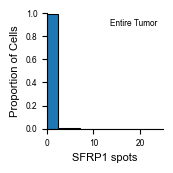

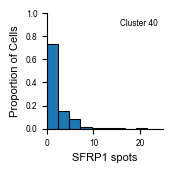

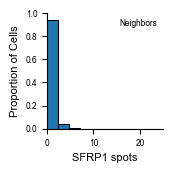

In [194]:
# now let's plot the distributino of clones within the clone, compared to neighboring cells and the entire tumor

cluster_of_interest = 40
# map nan to 0
counts, bins = np.histogram(sg_obj.gdf['SFRP1'].dropna().tolist(),)

# counts,bins = np.histogram(sg_obj.gdf['SFRP1'].dropna().tolist(),)

# counts,bins = np.histogram(sg_obj.gdf['SFRP1'].tolist(),)
plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Entire Tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(sg_obj.gdf['SFRP1'].dropna().tolist(),bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)


plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s=f'Cluster {cluster_of_interest}',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(cluster_cells['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_histograms_clone.pdf',bbox_inches='tight',transparent=True)


plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(neighboring_cells_only['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_histograms_neighbors.pdf',bbox_inches='tight',transparent=True)

# statstical test that means are different between the cluster and neighbors

from scipy.stats import ttest_ind
# t-test between the cluster and neighboring cells
t_stat, p_val = ttest_ind(cluster_cells['SFRP1'].dropna(), neighboring_cells_only['SFRP1'].dropna())
print(f'T-statistic: {t_stat}, P-value: {p_val}')

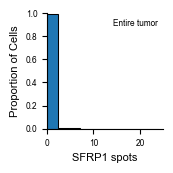

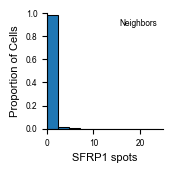

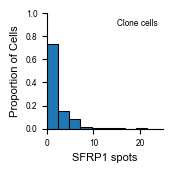

In [37]:
#### plot distributions of counts within the clone, compared to its neighborhood and the entire tumor 
# plt.subplots(figsize=(12,4),sharex=True,sharey=True)
# non_zero_cells = df[df['SFRP1']>1]
counts,bins = np.histogram(df['SFRP1'])

cluster_of_interest = 40

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s='Entire tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(df['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_full.pdf',bbox_inches='tight',transparent=True)

# print('Entire Tumor')
# print('Mean SFRP1 epxression:',df['SFRP1'].mean())
# print('Fraction of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1)/len(df))
# print('number of cells total:',len(df))
# print('number of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['cell_id'].isin(neighboring_cells)]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_neighbors.pdf',bbox_inches='tight',transparent=True)

# print('Neighbors')
# print('Mean SFRP1 expression:',df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'].mean())
# print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1)/len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
# print('number of cells total:',len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
# print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# clone 31
# ax = plt.subplot(1,3,1)
plt.text(s='Clone cells',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
sns.histplot(df[df['bc_cluster'].isin([40])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_hists.pdf',bbox_inches='tight')
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_clone31.pdf',bbox_inches='tight',transparent=True)

# print('clone 31')
# print('Mean SFRP1 expression:',df[df['bc_cluster'].isin([40])]['SFRP1'].mean())
# print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1)/len(df[df['object_id'].isin(manual_cluster['object_id'])]))
# print('number of cells total:',len(df[df['object_id'].isin(manual_cluster['object_id'])]))
# print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1))


# fig,ax = plt.subplots(figsize=(1.5,1.5))

# # entire tumor
# ax.scatter([tools.jitter_point(0,0.1) for x in df['SFRP1']],
#             df['SFRP1'],alpha=0.2)


# # neighbors
# neighbors = df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]
# ax.scatter([tools.jitter_point(1,0.1) for x in neighbors['SFRP1']],
#             neighbors['SFRP1'],alpha=0.2)

# # clone 31
# ax.scatter([tools.jitter_point(2,0.1) for x in df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']],
#             df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],alpha=0.2)
# # sns.histplot(,bins=bins,alpha=1.0,stat='proportion',ax=ax)

# plt.xticks(range(3),['entire tumor','Neighbors','Clone 31 cells'])
# # plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_jitter.pdf',bbox_inches='tight')

# fig,ax = plt.subplots(figsize=(4,4))
# plt.plot(np.linspace(0,1,len(df['SFRP1'])),
#          np.cumsum(df['SFRP1'].sort_values(ascending=False).values)/np.sum(df['SFRP1']),
#          label='Entire tumor')
# plt.plot(np.linspace(0,1,len(neighbors['SFRP1'])),
#          np.cumsum(neighbors['SFRP1'].sort_values(ascending=False).values)/np.sum(neighbors['SFRP1']),
#          label='Neighbors')
# plt.plot(np.linspace(0,1,len(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'])),
#          np.cumsum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].sort_values(ascending=False).values)/np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']),
#          label='Clone 31 cells')
# plt.legend()

# plt.ylabel('Cumulative proportion of spots')
# plt.xlabel('Proportion of cells in group (sorted)')



,bc_cluster,bc_cluster_bc_names,SFRP1
30244,40.0,bc_073,4.0
31394,40.0,bc_073,3.0
31510,40.0,bc_073,2.0
31959,40.0,bc_073,0.0
32075,40.0,bc_073,8.0
...,...,...,...
52992,40.0,bc_073,0.0
53151,40.0,bc_073,1.0
53213,40.0,bc_073,3.0
53352,40.0,bc_073,4.0


<AxesSubplot: >

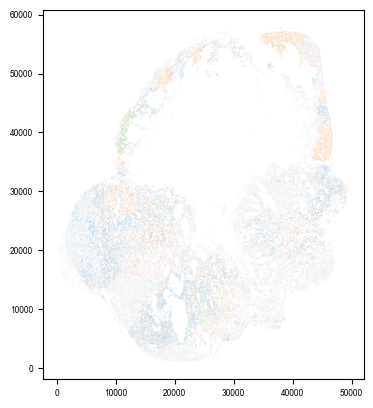

In [174]:
sg_obj.gdf.plot(column='bc_cluster',categorical=True,lw=0.01,alpha=0.2,missing_kwds= dict(color = "lightgrey",),cmap='tab20')

In [130]:
box_lims[roi_of_interest][1]

[18000, 23000, 48000, 57000]

In [ ]:
sg_obj.gdf.within()

In [138]:
sg_obj.gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
0,"POLYGON ((20452.000 978.000, 20472.000 980.000...","POLYGON ((20366.000 1040.661, 20365.685 1041.3...",POINT (20442.252 1036.183),20442.252084,1036.182508,14465.012042,1,1,1.0,0.0,...,0.0,0.0,1.0,0.0,705.0,bc_074,['bc_074'],1.0,['bc_074'],1.0
1,"POLYGON ((20899.000 1116.000, 20919.000 1120.0...","POLYGON ((20893.700 1107.520, 20885.700 1112.5...",POINT (20934.446 1155.448),20934.446389,1155.447838,8310.292671,10,10,2.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
2,"POLYGON ((23405.000 1289.000, 23422.000 1289.0...","POLYGON ((23401.154 1279.769, 23389.154 1284.7...",POINT (23427.302 1328.096),23427.302149,1328.095541,8030.740341,100,100,5.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
3,"POLYGON ((22362.000 2604.000, 22371.000 2604.0...","POLYGON ((22354.191 2597.753, 22350.191 2602.7...",POINT (22391.950 2660.513),22391.949684,2660.512711,7791.201110,1000,1000,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
4,"POLYGON ((34450.000 9802.000, 34456.000 9802.0...","POLYGON ((34410.776 9860.918, 34421.929 9872.0...",POINT (34434.629 9833.058),34434.628857,9833.058403,4928.902676,10000,10000,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79141,"POLYGON ((21998.000 9799.000, 22000.000 9799.0...","POLYGON ((21994.227 9789.739, 21968.317 9800.2...",POINT (21987.939 9828.897),21987.939394,9828.897300,5500.544273,9995,9995,0.0,0.0,...,0.0,0.0,0.0,0.0,410.0,bc_001-bc_031-bc_087,"['bc_001', 'bc_031', 'bc_087']",3.0,"['bc_024', 'bc_029', 'bc_031', 'bc_087']",4.0
79142,"POLYGON ((17051.000 9800.000, 17090.000 9803.0...","POLYGON ((17048.710 9790.266, 17031.710 9794.2...",POINT (17057.349 9832.790),17057.348683,9832.790086,7029.281662,9996,9996,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,['bc_002'],1.0
79143,"POLYGON ((25990.000 9800.000, 26006.000 9801.0...","POLYGON ((25985.528 9791.056, 25975.528 9796.0...",POINT (26005.495 9880.858),26005.494746,9880.858088,20049.671924,9997,9997,4.0,0.0,...,0.0,0.0,0.0,0.0,90.0,bc_060-bc_077-bc_092,"['bc_060', 'bc_077', 'bc_092']",3.0,"['bc_060', 'bc_077', 'bc_092']",3.0
79144,"POLYGON ((29231.000 9800.000, 29239.000 9800.0...","POLYGON ((29224.753 9792.191, 29214.753 9800.1...",POINT (29248.028 9850.902),29248.027506,9850.902230,5990.908719,9998,9998,3.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,['bc_022'],1.0


In [136]:
# filter the gdf to cells within the bbox

this_region = sg_obj.gdf.loc[sg_obj.gdf.within(box(*box_lims[roi_of_interest][1]))]

In [137]:
this_region

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
35036,"POLYGON ((18157.000 23010.000, 18177.000 23011...","POLYGON ((18153.838 23000.513, 18147.357 23002...",POINT (18156.052 23073.496),18156.052035,23073.495533,15727.641955,41530,41530,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
35037,"POLYGON ((37423.000 23010.000, 37427.000 23012...","POLYGON ((37414.863 23004.188, 37404.863 23018...",POINT (37444.402 23065.589),37444.402455,23065.589093,6450.640608,41531,41531,2.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,['bc_085'],1.0
35039,"POLYGON ((19103.000 23011.000, 19123.000 23025...","POLYGON ((19053.127 23018.485, 19044.243 23026...",POINT (19082.883 23071.562),19082.882507,23071.562116,12842.863444,41533,41533,2.0,0.0,...,0.0,0.0,0.0,0.0,1070.0,bc_016-bc_073,"['bc_016', 'bc_073']",2.0,"['bc_016', 'bc_073']",2.0
35040,"POLYGON ((19216.000 23012.000, 19242.000 23012...","POLYGON ((19213.127 23002.422, 19193.127 23008...",POINT (19227.259 23055.240),19227.259226,23055.240193,10550.647197,41534,41534,4.0,0.0,...,0.0,0.0,0.0,0.0,877.0,bc_016-bc_057-bc_073,"['bc_016', 'bc_057', 'bc_073']",3.0,"['bc_016', 'bc_057', 'bc_073', 'bc_084']",4.0
35041,"POLYGON ((40481.000 23012.000, 40496.000 23014...","POLYGON ((40478.831 23002.238, 40469.831 23004...",POINT (40502.027 23103.855),40502.026976,23103.854655,18477.339100,41535,41535,14.0,1.0,...,0.0,0.0,0.0,0.0,488.0,bc_009-bc_039,"['bc_009', 'bc_039']",2.0,"['bc_009', 'bc_013', 'bc_039']",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76604,"POLYGON ((35191.000 56902.000, 35227.000 56903...","POLYGON ((35187.286 56892.715, 35177.286 56896...",POINT (35218.632 56925.209),35218.632445,56925.208633,5647.510064,78943,78943,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
76608,"POLYGON ((34237.000 56912.000, 34248.000 56913...","POLYGON ((34235.039 56902.194, 34225.039 56904...",POINT (34235.111 56932.583),34235.110973,56932.583333,3408.236668,78947,78947,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
76613,"POLYGON ((27182.000 56922.000, 27189.000 56922...","POLYGON ((27175.243 56914.628, 27163.243 56925...",POINT (27180.820 56941.893),27180.820022,56941.893138,2349.310329,78951,78951,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76614,"POLYGON ((36914.000 56923.000, 36947.000 56925...","POLYGON ((36904.555 56919.715, 36896.555 56942...",POINT (36929.716 56947.422),36929.715994,56947.422123,3840.369813,78952,78952,1.0,0.0,...,0.0,0.0,0.0,0.0,367.0,bc_009-bc_034-bc_040,"['bc_009', 'bc_034', 'bc_040']",3.0,"['bc_009', 'bc_034', 'bc_040']",3.0


Entire Tumor
Mean SFRP1 epxression: 0.10002678491711556
Fraction of cells with SFRP1 > 1: 0.015088836641766613
number of cells total: 67202
number of cells with SFRP1 > 1: 1014
Neighbors
Mean SFRP1 expression: 0.17717842323651453
Fraction of cells with SFRP1 > 1: 0.033609958506224065
number of cells total: 2410
number of cells with SFRP1 > 1: 81
clone 31
Mean SFRP1 expression: 3.7468354430379747
Fraction of cells with SFRP1 > 1: 0.5822784810126582
number of cells total: 79
number of cells with SFRP1 > 1: 46


Text(0.5, 0, 'Proportion of cells in group (sorted)')

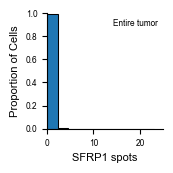

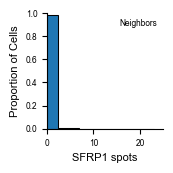

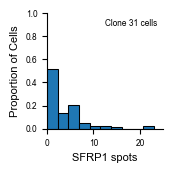

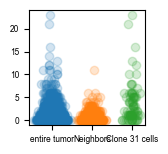

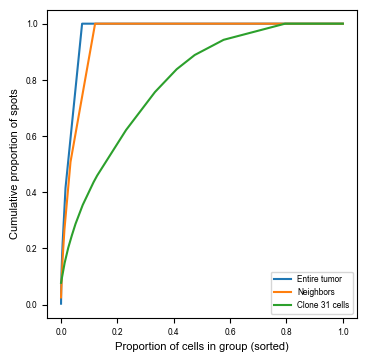

In [ ]:
#### plot distributions of counts within the clone, compared to its neighborhood and the entire tumor 
# plt.subplots(figsize=(12,4),sharex=True,sharey=True)
# non_zero_cells = df[df['SFRP1']>1]
counts,bins = np.histogram(df['SFRP1'])

cluster_of_interest = 31

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s='Entire tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(df['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_full.pdf',bbox_inches='tight',transparent=True)

print('Entire Tumor')
print('Mean SFRP1 epxression:',df['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1)/len(df))
print('number of cells total:',len(df))
print('number of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_neighbors.pdf',bbox_inches='tight',transparent=True)

print('Neighbors')
print('Mean SFRP1 expression:',df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1)/len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells total:',len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# clone 31
# ax = plt.subplot(1,3,1)
plt.text(s='Clone 31 cells',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
sns.histplot(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_hists.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_clone31.pdf',bbox_inches='tight',transparent=True)

print('clone 31')
print('Mean SFRP1 expression:',df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1)/len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells total:',len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1))


fig,ax = plt.subplots(figsize=(1.5,1.5))

# entire tumor
ax.scatter([tools.jitter_point(0,0.1) for x in df['SFRP1']],
            df['SFRP1'],alpha=0.2)


# neighbors
neighbors = df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]
ax.scatter([tools.jitter_point(1,0.1) for x in neighbors['SFRP1']],
            neighbors['SFRP1'],alpha=0.2)

# clone 31
ax.scatter([tools.jitter_point(2,0.1) for x in df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']],
            df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],alpha=0.2)
# sns.histplot(,bins=bins,alpha=1.0,stat='proportion',ax=ax)

plt.xticks(range(3),['entire tumor','Neighbors','Clone 31 cells'])
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_jitter.pdf',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(4,4))
plt.plot(np.linspace(0,1,len(df['SFRP1'])),
         np.cumsum(df['SFRP1'].sort_values(ascending=False).values)/np.sum(df['SFRP1']),
         label='Entire tumor')
plt.plot(np.linspace(0,1,len(neighbors['SFRP1'])),
         np.cumsum(neighbors['SFRP1'].sort_values(ascending=False).values)/np.sum(neighbors['SFRP1']),
         label='Neighbors')
plt.plot(np.linspace(0,1,len(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'])),
         np.cumsum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].sort_values(ascending=False).values)/np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']),
         label='Clone 31 cells')
plt.legend()

plt.ylabel('Cumulative proportion of spots')
plt.xlabel('Proportion of cells in group (sorted)')

